In [1]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.fairness_functions import reshape_general_violent_cond_auc_summaries

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa-analysis


In [3]:
# read in Broward/Kentucky BNC/BPC data for prediction problems of interest
bpc_bnc_data = {}
for time_period in [
#                     "six-month", 
                    "two-year"
                    ]:
    
    for problem in ['general', 'violent']:
        for region, pn_folder_name in {'broward': "condition-pn", 'kentucky': "condition-pn"}.items():
            problem_path = region + "/" +  pn_folder_name + "/" + time_period + "/" + problem
            dircontents = os.listdir()
            if os.path.isdir(problem_path):
                onlyfiles = [f for f in os.listdir(problem_path) if os.path.isfile(os.path.join(problem_path, f))]
            else: 
                continue
            for filename in onlyfiles:
                model_name = filename.split("_")[0]
                if model_name in ['ebm', 'riskslim', 'compas', 'arnold']:
                    bpc_bnc_data["-".join((region, problem, time_period, model_name))] = pd.read_csv(problem_path + "/" + filename)

bpc_bnc_data.keys()

dict_keys(['broward-general-two-year-arnold', 'broward-general-two-year-compas', 'broward-general-two-year-ebm', 'broward-general-two-year-riskslim', 'kentucky-general-two-year-arnold', 'kentucky-general-two-year-ebm', 'kentucky-general-two-year-riskslim', 'broward-violent-two-year-arnold', 'broward-violent-two-year-compas', 'broward-violent-two-year-ebm', 'broward-violent-two-year-riskslim', 'kentucky-violent-two-year-arnold', 'kentucky-violent-two-year-ebm', 'kentucky-violent-two-year-riskslim'])

In [4]:
bpc_bnc_data['broward-violent-two-year-arnold']['Attribute Value'].unique()

KeyError: 'broward-violent-six-month-arnold'

In [64]:
bpc_bnc_data['kentucky-violent-two-year-arnold']['Attribute Value'].unique()

array(['African-American', 'Caucasian', 'Other', 'male', 'female'],
      dtype=object)

## BPC and BNC
A score $S$ is **balanced for the positive class** if 
$$
E[S |Y = 1,G = g_i] = E[S |Y = 1,G = g_j],\forall i \neq j \in \alpha.
$$

Similarly, a score $S$ satisfies **balance for negative class** (BNC) if

$$
E[S |Y = 0,G = g_i] = E[S |Y = 0,G = g_j],\forall i \neq j \in \alpha.
$$


In [5]:
def summarize_bpc_bnc_data(bpc_bnc_df:pd.DataFrame,
                           problem_name:str):
    """
    Summarize balance for positive class and negative class output.
    """
    summary = (bpc_bnc_df
                 .drop(columns=["fold_num"])
                 .groupby(["Attribute", "Attribute Value", "Label"])
                 .agg('mean')
                 .reset_index()
                 .replace({"Label": {0: "bnc",
                                     1: "bpc"}})
              )

    summary['Label Name'] = f'{problem_name}_'
    summary['Label'] = summary['Label Name'] + summary['Label']
    del summary['Label Name']

    return summary


def combine_general_violent_summaries(general_summary,
                                      violent_summary):
    """
    """
    combi_df = (pd.concat([general_summary, violent_summary])
                    .replace({"Attribute Value": {"African-American": "Afr-Am.",
                                                  "Other": "Other Race",
                                                  "Hispanic": "Hisp.",
                                                  "Caucasian": "Cauc.",
                                                  "female": "Female", 
                                                  "male": "Male"}}))
 
    wide_df = combi_df.pivot(index="Label",
                       columns="Attribute Value",
                       values=["Expected Score"])
    
    col_order = ['Afr-Am.', 'Cauc.', 'Hisp.', "Other Race", "Female", "Male"]
    # check if Kentucky
    if "Hispanic" not in combi_df['Attribute Value'].unique():
        col_order = ['Afr-Am.', 'Cauc.', "Other Race", "Female", "Male"]
        
    wide_df = wide_df.T.reindex(col_order, level=1).T

    return wide_df

In [6]:
from utils.plotting_helpers import safe_save_plt

def plot_bpc_bnc(wide_df,
                 model_name:str,
                 region:str,
                 save_path=None):
    """
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('ggplot')

    attribute_values = wide_df.columns.get_level_values(1)
    barWidth = 0.12

    bars = {attribute_value: {"bar": None, "pos": None} for attribute_value in attribute_values}
    for attribute_value in attribute_values:
        bars[attribute_value]["bar"] = wide_df[('Expected Score', attribute_value)]
        bar_len = len(bars[attribute_value]["bar"])

    # Set position of bar on X axis
    for i, (bar_name, bar_dict) in enumerate(bars.items()):
        if i == 0:
            bar_dict["pos"] = np.arange(len(bar_dict["bar"]))
        else: 
            prev_bar_pos = bars[prev_bar_name]["pos"]
            bar_dict["pos"] = [x + barWidth for x in prev_bar_pos]
        prev_bar_name = bar_name 

    colors = {"Afr-Am.": 'cornflowerblue',
              "Other Race": 'lightslategrey',
              "Hisp.": 'lightskyblue',
              "Cauc.": 'steelblue',
              "Female": 'lightcoral', 
              "Male": 'pink'}
    for i, (bar_name, bar_dict) in enumerate(bars.items()):
        plt.bar(bar_dict["pos"], 
              bar_dict["bar"], 
              color=colors[bar_name], 
              width=barWidth, 
              edgecolor='white', 
              label=f"{bar_name}")

    # Add xticks on the middle of the group bars
    region_cap = region.capitalize()
    plt.xlabel(f'\nTwo Yr Problems, {region_cap}', fontsize=25)

    xtick_labels = list(wide_df.index)
    plt.xticks(np.arange(len(xtick_labels))+.2, xtick_labels, rotation=20)
    plt.tick_params(axis="x", labelsize=20)

    # y axis formatting
    if model_name == "COMPAS":
        plt.ylim(0,11)
        plt.axhline(y=10, color='firebrick', linestyle='--', alpha=.8)
    elif model_name == "Arnold":
        plt.ylim(0,8)
        plt.axhline(y=6, color='firebrick', linestyle='--', alpha=.8)
        plt.axhline(y=7, color='firebrick', linestyle='--', alpha=.8)
    else:
        plt.ylim(0,1.05)
        plt.axhline(y=1, color='firebrick', linestyle='--', alpha=.8)

    plt.tick_params(axis="y", labelsize=25)

    if region == "broward":
        plt.legend(fontsize=20, ncol=2)
    else:
        plt.ylabel(f'E({model_name} | Attr = attr, Y = i)', fontsize=25)

    plt.title(f"BPC/BNC for {model_name}", fontsize = 30)

    if save_path is not None:
        safe_save_plt(plt, save_path)
    plt.show()
    plt.close()
    return

# test out a plot to visualize this 
def plot_bpc_bnc_kentucky_broward(wide_dfs,
                                 model_name, 
                                 save_path=None):
    '''Plots the BPC and BNC for all races, across 2 yr general and violent recid, 
    for both broward and kentucky. 
    Keyword arguments
    wide_dfs: dictionary of pandas dataframes, where the key is the region name (i.e. broward/kentucky)
    '''

    plt.style.use('ggplot')
    fig, axes = plt.subplots(figsize=(14, 6.5), ncols=2)
    axes_dict = {"kentucky": axes[0], 
                 "broward": axes[1]}

    # set width of bar
    barWidth = 0.12

    for region, wide_df in wide_dfs.items():
        # set height of bar
        attribute_values = wide_dfs[region].columns.get_level_values(1)

        bars = {attribute_value: {"bar": None, "pos": None} for attribute_value in attribute_values}
        for attribute_value in attribute_values:
            bars[attribute_value]["bar"] = wide_df[('Expected Score', attribute_value)]
            bar_len = len(bars[attribute_value]["bar"])

        # Set position of bar on X axis
        for i, (bar_name, bar_dict) in enumerate(bars.items()):
            if i == 0:
                bar_dict["pos"] = np.arange(len(bar_dict["bar"]))
            else: 
                prev_bar_pos = bars[prev_bar_name]["pos"]
                bar_dict["pos"] = [x + barWidth for x in prev_bar_pos]
            prev_bar_name = bar_name 

        colors = {"Afr-Am.": 'cornflowerblue',
                  "Other Race": 'lightslategrey',
                  "Hisp.": 'lightskyblue',
                  "Cauc.": 'steelblue',
                  "Female": 'lightcoral', 
                  "Male": 'pink'}
        for i, (bar_name, bar_dict) in enumerate(bars.items()):
            axes_dict[region].bar(bar_dict["pos"], 
                  bar_dict["bar"], 
                  color=colors[bar_name], 
                  width=barWidth, 
                  edgecolor='white', 
                  label=f"{bar_name}")

        # Add xticks on the middle of the group bars
        region_cap = region.capitalize()
        axes_dict[region].set_xlabel(f'\nTwo Yr Problems, {region_cap}', fontsize=25)

        xtick_labels = list(wide_dfs[region].index)
        axes_dict[region].set_xticks(np.arange(len(xtick_labels))+.2)
        axes_dict[region].set_xticklabels(list(xtick_labels))
        axes_dict[region].tick_params(axis="x", labelsize=20, rotation=20)

        # y axis formatting
        if model_name == "COMPAS":
            axes_dict[region].set_ylim(0,11)
            axes_dict[region].axhline(y=10, color='firebrick', linestyle='--', alpha=.8)

        elif model_name == "Arnold":
            axes_dict[region].set_ylim(0,8)
            axes_dict[region].axhline(y=6, color='firebrick', linestyle='--', alpha=.8)
            axes_dict[region].axhline(y=7, color='firebrick', linestyle='--', alpha=.8)

        else:
            axes_dict[region].set_ylim(0,1.05)
            axes_dict[region].axhline(y=1, color='firebrick', linestyle='--', alpha=.8)
        
        axes_dict[region].tick_params(axis="y", labelsize=25)

        if region == "broward":
            axes_dict[region].legend(fontsize=20, ncol=2)
        else: 
            axes_dict[region].set_ylabel(f'E({model_name} | Attr = attr, Y = i)', fontsize=25)


    # title and formatting
    fig.suptitle(f"BPC/BNC for {model_name}", fontsize = 30)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    
    if save_path is not None:
        safe_save_plt(plt, save_path)
        
    plt.show()
    plt.close()
    

## Plot BPC and BNC

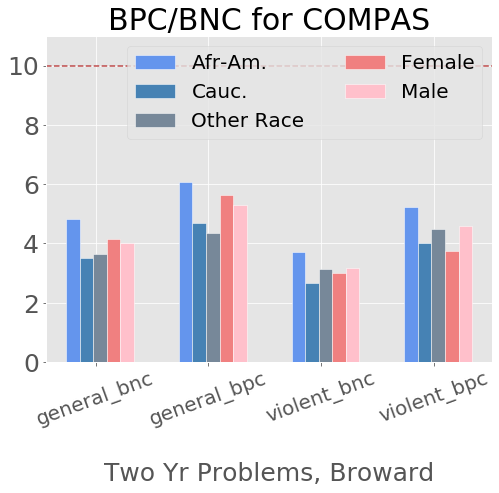

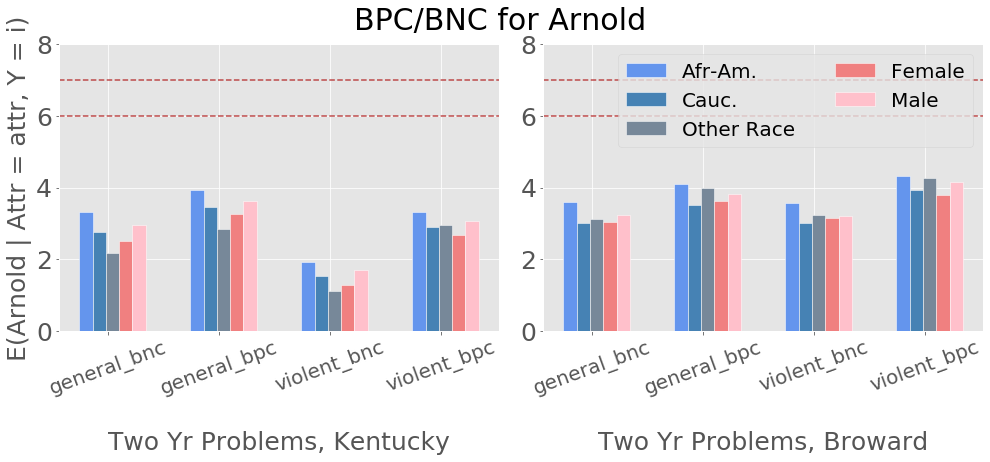

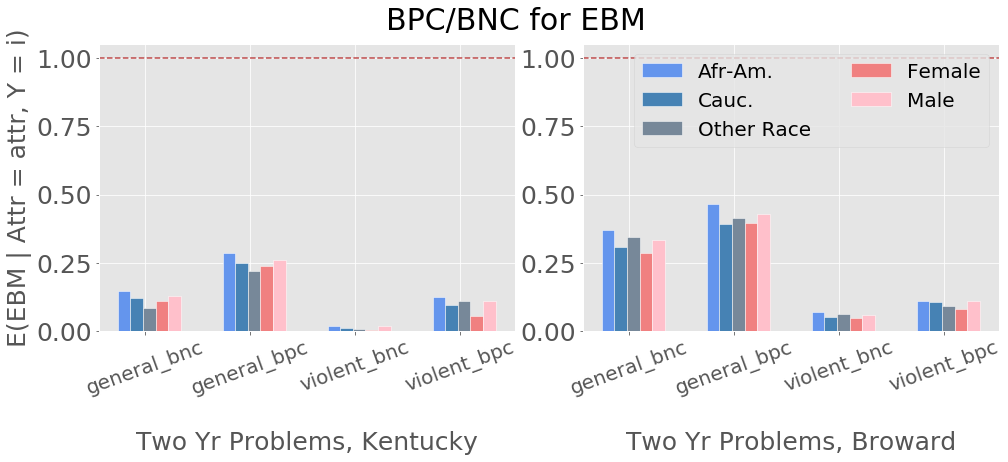

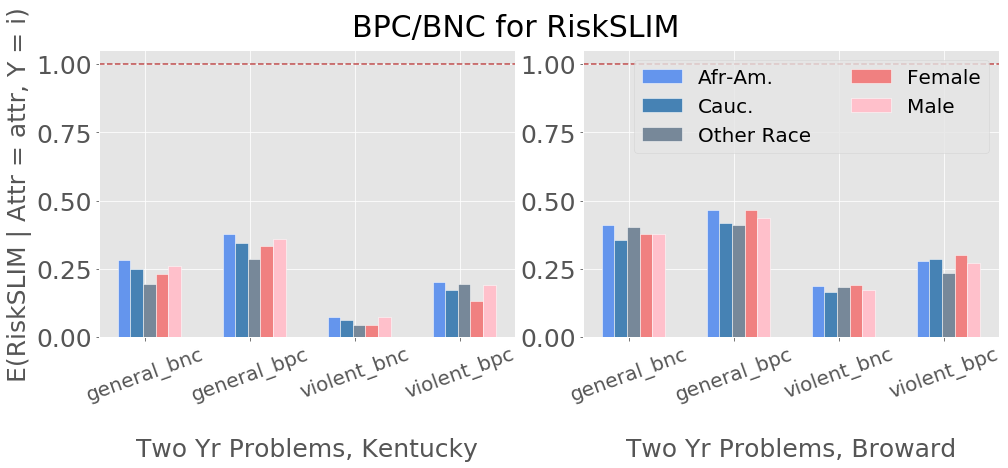

In [7]:
for model_name in [
                   'COMPAS', 
                   'Arnold', 
                   'EBM', 
                   'RiskSLIM'
                  ]:
    
    model_name_lower = model_name.lower()
    wide_dfs = {"kentucky": None, "broward": None}
    
    for region in ['broward', 'kentucky']:
        if model_name == "COMPAS" and region == "kentucky": 
            continue
            
        general_summary = summarize_bpc_bnc_data(bpc_bnc_df=bpc_bnc_data[f'{region}-general-two-year-{model_name_lower}'],
                                                                problem_name="general")

        violent_summary = summarize_bpc_bnc_data(bpc_bnc_df=bpc_bnc_data[f'{region}-violent-two-year-{model_name_lower}'],
                                                                problem_name="violent")
        wide_df = combine_general_violent_summaries(general_summary=general_summary,
                                                    violent_summary=violent_summary)
        wide_dfs[region] = wide_df

    if model_name == 'COMPAS': 
        # special plotting routine because only the Broward df will be filled
        plot_bpc_bnc(wide_dfs['broward'],
                     model_name='COMPAS',
                     region='broward',
                     save_path="broward/logs/fairness_results/bpc_bnc_visualizations/compas_bpc_bnc.pdf")
        continue

    else:
        plot_bpc_bnc_kentucky_broward(wide_dfs,
                                     model_name=model_name,
                                     save_path=f"broward/logs/fairness_results/bpc_bnc_visualizations/{model_name_lower}_bpc_bnc.pdf")